In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
print(soccfg)

resetting clocks: 204.8

QICK configuration:

	Board: ZCU111

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, switch ch 0, maxlen 65536
		DAC tile 0, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	1:	axis_signal_gen_v4 - tProc output 2, switch ch 1, maxlen 65536
		DAC tile 0, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	2:	axis_signal_gen_v4 - tProc output 3, switch ch 2, maxlen 65536
		DAC tile 0, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	3:	axis_signal_gen_v4 - tProc output 4, switch ch 3, maxlen 65536
		DAC tile 1, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	4:	axis_signal_gen_v4 - tProc output 5, switch ch 4, maxlen 65536
		DAC tile 1, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	5:	axis_signal_gen_v4 - tProc output 6, switch ch 5, maxlen 65536
		DAC tile 1, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	6:	axis_signal_gen_v4 - tProc out

### Hardware Configuration

generator channel 6   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0

In [3]:
def find_start_and_stop(sample_array):
    start_end_list = [0]
    initial = sample_array[0]
    flag = 0
    if initial > 0:
        flag = 1        
    for i in range(len(sample_array)):
        if flag == 1 and sample_array[i] == 0:
            start_end_list.append(i)
            flag = 0
        elif flag == 0 and sample_array[i] > 0:
            start_end_list.append(i)
            flag = 1
    start_end_list.append(len(sample_array))
    
    return_list = []
    for i in range(len(start_end_list)-1):
        return_list.append(sample_array[start_end_list[i]:start_end_list[i+1]])
    return return_list
            

In [4]:
def array_splitter(array_list):
    start_end_list = [0]
    flag_list = []
    for i in range(len(array_list)):
        if array_list[i][0] > 0:
            flag_list.append(1)
        elif array_list[i][0] == 0:
            flag_list.append(0)
    
    
    for i in range(len(array_list[0])):
        for j in range(len(array_list)):
            if flag_list[j] == 1 and array_list[j][i] ==0:
                start_end_list.append(i)
                flag_list[j] = 0
                break
            elif flag_list[j] == 0 and array_list[j][i] > 0:
                start_end_list.append(i)
                flag_list[j] = 1
                break
    start_end_list.append(len(array_list[0]))
    #print(start_end_list)

    #start_end_list = list(set(start_end_list))
    print(start_end_list)
    return_list = []
    for i in range(len(start_end_list)-1):
        return_list.append(array_list[:,start_end_list[i]:start_end_list[i+1]].tolist())
    
    return return_list
        

In [5]:
import pandas as pd

df = pd.read_excel('sample_sequence.xls', header = None)


In [6]:
NV_I = list(np.array(np.abs(df[0]).astype(int)))
NV_Q = list(np.array(np.abs(df[1]).astype(int)))
NV_Switch = list(np.array(np.abs(df[2]).astype(int)))
DAQ = list((np.array(df[3]).astype(int)))
Laser = list((np.array(df[4]).astype(int)))

array_list = np.array([DAQ, Laser])
#array_list = np.array([NV_Q])

sequence_list = array_splitter( array_list ) 

#plt.plot(sequence_list[6][0])
#plt.plot(sequence_list[6][1])
#len(sequence_list[0])
#sequence_list

[0, 10000, 11362, 11862, 13162, 21362, 22565, 23065, 24365, 32565, 33360]


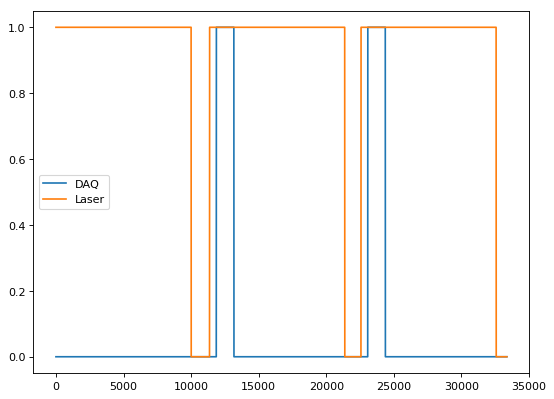

In [7]:
figure(figsize=(8, 6), dpi=80)
#plt.plot(  NV_I, label = "NV_I" ) 
#plt.plot( NV_Q, label = "NV_Q" ) 
#plt.plot(  NV_Switch, label = "NV_Switch" ) 
plt.plot(  list(np.array(df[3])), label = "DAQ" ) 
plt.plot(  list(np.array(df[4])), label = "Laser" ) 
len(np.array(df[4]))
plt.legend()

In [183]:
class LoopbackProgram(AveragerProgram):
        
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        phase_2 = self.deg2reg(cfg["res_phase_2"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]

        style=self.cfg["pulse_style"]

        self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=phase, gain=gain,
                                     length=cfg["length"])
        
        
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.pulse(ch=self.cfg["res_ch"], t = 0)
        cfg=self.cfg   

        res_ch = cfg["res_ch"]
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        phase_2 = self.deg2reg(cfg["res_phase_2"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]

        style=self.cfg["pulse_style"]

        self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=phase_2, gain=gain,
                                     length=cfg["length"])
        
        self.pulse(ch=self.cfg["res_ch"], t = 100)
        
        cumulative_seq_length = 0 #nanoseconds
        trig_output = self.soccfg['tprocs'][0]['trig_output'] #usually just 0
        for sequence in sequence_list:
            initial_pin = 0
            pins_list = []
            for pin in sequence:
                if pin[0] == 1:
                    pins_list.append(initial_pin)
                initial_pin += 1
            if len(pins_list) > 0:
                out = 0
                for pin in pins_list:
                    out |= (1 << pin)
                t_start = round(cumulative_seq_length/2.6)
                t_end = t_start + round(len(sequence[0])/2.6)
                self.regwi(0, 31, out, f'out = 0b{out:>016b}')
                self.seti(trig_output, 0, 31, t_start, f'ch =0 out = ${31} @t = {t_start}')
                
            else:
                self.seti(trig_output, 0, 0, t_end, f'ch =0 out = 0 @t = {t_start}')
            cumulative_seq_length += len(sequence[0]) #nanoseconds


        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [185]:
config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "res_phase_2":0, # --degrees
        
        "pulse_style": "const", # --Fixed
        
        "length":100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 200, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 150, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [187]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]
        I_data = self.cfg["idata"]

        self.add_pulse(ch = res_ch, name ="measure", idata = I_data)
        self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", outsel = "input")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.pulse(ch=self.cfg["res_ch"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [143]:

si=25*16
maxv=30000
length = 1600
mu = length/2 - 0.5
x = np.arange(0, length)
I = -maxv * np.exp(-(x-mu)**2/si**2)
config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "arb", # --Fixed

        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100,
        # Try varying soft_avgs from 1 to 200 averages
        "idata": I
       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


  0%|          | 0/100 [00:00<?, ?it/s]

In [145]:
x = np.arange(0, 1600)
first_half = -(30000/(1600**2))*(x**2)
second_half = np.flip(first_half)
combined = np.concatenate( (first_half, second_half) )
I = combined
n = 5
for i in range(n):
    I = np.concatenate( (I, combined) )
config={"res_ch":6, # --Fixed 
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "arb", # --Fixed

        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100,
        # Try varying soft_avgs from 1 to 200 averages
        "idata": I
       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


  0%|          | 0/100 [00:00<?, ?it/s]

In [180]:
length = 160
x = np.arange(0, length)
def f(z):
    return z**0.5
first_half = -(15000/(f(length)))*(f(x))
second_half = np.flip(first_half)
combined = np.concatenate( (first_half, second_half) )
I = combined
n = 5
for i in range(n):
    I = np.concatenate( (I, combined) )
config={"res_ch":6, # --Fixed 
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "arb", # --Fixed

        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100,
        # Try varying soft_avgs from 1 to 200 averages
        "idata": I
       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [211]:
length = 1600
x = np.arange(0, length)
def f(z):
    return np.sin((100*(10**6)/(2.6*10**(-9)) )*z)
first_half = -(18000)*(f(x) + f(2*x))

I = first_half

config={"res_ch":6, # --Fixed 
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "arb", # --Fixed

        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100,
        # Try varying soft_avgs from 1 to 200 averages
        "idata": I
       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

  0%|          | 0/100 [00:00<?, ?it/s]